# Detecting Depression on Social Media Using Deep Learning

## Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import ftfy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from math import exp
from numpy import sign 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.util import bigrams, trigrams, ngrams
from wordcloud import WordCloud,STOPWORDS

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

## Data Collection Using Twint

In [ ]:
import twint
import datetime
import nest_asyncio
nest_asyncio.apply()

In [ ]:
all_country =['USA', 'Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova, Republic of', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan, Province of China', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Virgin Islands, British', 'Virgin Islands, U.S.', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe']

In [ ]:
def scrape_by_country(outfile):
    unique_country=set(all_country) #To get unique cities of country
    countries = sorted(unique_country) #Sort & convert datatype to list
    for country in countries:
        print(country)
        c = twint.Config()
        c.Search = '' #search keyword
        c.Since = str(datetime.datetime(2018, 3, 1))
        c.Until = str(datetime.datetime(2022, 3, 1))
        c.Store_csv = True
        c.Output = "./" + outfile
        c.Near = country
        c.Hide_output = True
        c.Count = True
        c.Stats = True
        c.Lang = 'en'
        c.Resume = 'resume.txt'
        c.Limit = 1000
        twint.run.Search(c)

scrape_by_country('Mental_Tweets_Dataset.csv')

## Load the Datasets

In [4]:
depressive_tweets_df = pd.read_csv(r'C:\Users\katle\PycharmProjects\AIMT Term 2\AML 2304\Detecting Depression using Tweets\depressed_tweets.csv')
random_tweets_df = pd.read_csv(r'C:\Users\katle\PycharmProjects\AIMT Term 2\AML 2304\Detecting Depression using Tweets\random_tweets.csv')

EMBEDDING_FILE = r'C:\Users\katle\PycharmProjects\AIMT Term 2\AML 2304\Detecting Depression using Tweets\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin'

In [5]:
depressive_tweets_df.shape

(13649, 37)

In [6]:
random_tweets_df.shape

(20215, 37)

## Exploratory Data Analysis

### Text Preprocessing 

In [7]:
#Constants #Reproducibility #Try later

np.random.seed(1234)
DEPRES_NROWS = 12000 # number of rows to read from depressive_tweets
RANDOM_NROWS = 12000 # number of rows to read from random_tweets
MAX_SEQUENCE_LENGTH = 140 # max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS = 10

In [8]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [9]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [10]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        #if re.match('(\w+:\/\/\S+)', tweet) == None and len(tweet) > 10:
        tweet = ' '.join(re.sub('(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)', ' ', tweet).split())

        tweet = ftfy.fix_text(tweet)
            
        tweet = expandContractions(tweet)
            
        tweet = ' '.join(re.sub('([^0-9A-Za-z \t])', ' ', tweet).split())
        tweet = ' '.join(re.sub('http\S+', ' ', tweet).split())
            
        myOwn_stopwords = ['depress']
        stop_words = set(stopwords.words('english') + myOwn_stopwords)
        word_tokens = nltk.word_tokenize(tweet)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
            
        tweet = PorterStemmer().stem(tweet)
            
        cleaned_tweets.append(tweet)
            
    return cleaned_tweets 

### Sentiment Analysis

In [11]:
sid = SentimentIntensityAnalyzer()
depressive_tweets_df['sentiments']           = depressive_tweets_df['tweet'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
depressive_tweets_df['positive sentiment']   = depressive_tweets_df['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
depressive_tweets_df['neutral sentiment']    = depressive_tweets_df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
depressive_tweets_df['negative sentiment']   = depressive_tweets_df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
depressive_tweets_df['compound']  = depressive_tweets_df['sentiments'].apply(lambda score_dict: score_dict['compound'])
depressive_tweets_df['comp_score'] = depressive_tweets_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [12]:
random_tweets_df['sentiments']           = random_tweets_df['tweet'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
random_tweets_df['positive sentiment']   = random_tweets_df['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
random_tweets_df['neutral sentiment']    = random_tweets_df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
random_tweets_df['negative sentiment']   = random_tweets_df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
random_tweets_df['compound']  = random_tweets_df['sentiments'].apply(lambda score_dict: score_dict['compound'])
random_tweets_df['comp_score'] = random_tweets_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

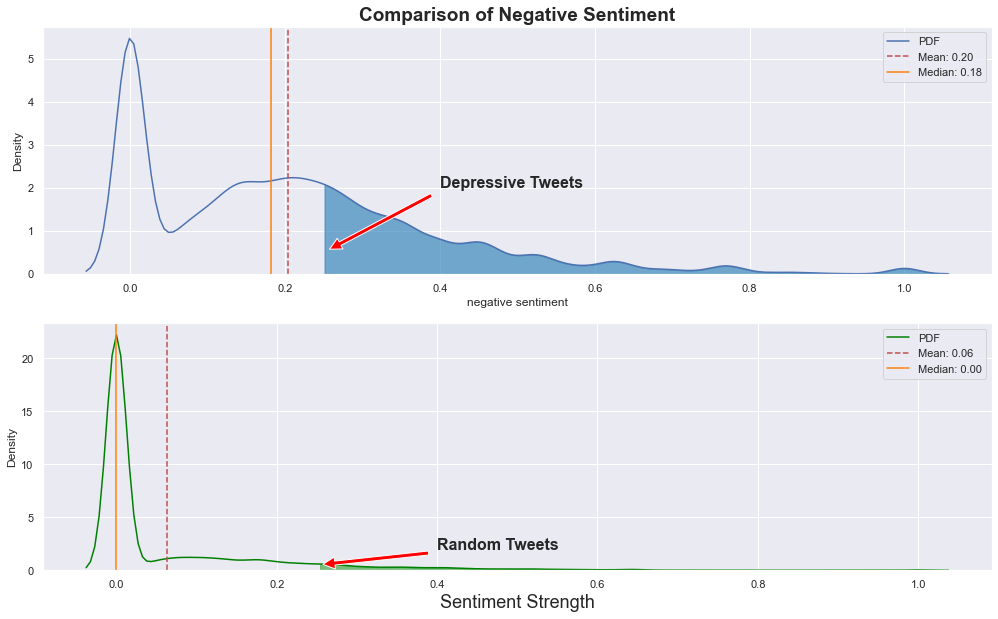

In [15]:
sns.set(rc={"figure.figsize":(17, 10)})
plt.subplot(2,1,1)
plt.title('Comparison of Negative Sentiment',fontsize=19,fontweight='bold')

ax0 = sns.kdeplot(depressive_tweets_df['negative sentiment'],bw=0.1)

kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='tab:blue',alpha=0.6)

plt.annotate('Depressive Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')

ax0.axvline(depressive_tweets_df['negative sentiment'].mean(), color='r', linestyle='--')
ax0.axvline(depressive_tweets_df['negative sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':depressive_tweets_df['negative sentiment'],r'Mean: {:.2f}'.format(depressive_tweets_df['negative sentiment'].mean()):depressive_tweets_df['negative sentiment'].mean(),
            r'Median: {:.2f}'.format(depressive_tweets_df['negative sentiment'].median()):depressive_tweets_df['negative sentiment'].median()})


plt.subplot(2,1,2)

ax1 = sns.kdeplot(random_tweets_df['negative sentiment'],bw=0.1,color='green')

plt.annotate('Random Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='tab:green',alpha=0.6)
ax1.set_xlabel('Sentiment Strength',fontsize=18)


ax1.axvline(random_tweets_df['negative sentiment'].mean(), color='r', linestyle='--')
ax1.axvline(random_tweets_df['negative sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':random_tweets_df['negative sentiment'],r'Mean: {:.2f}'.format(random_tweets_df['negative sentiment'].mean()):random_tweets_df['negative sentiment'].mean(),
            r'Median: {:.2f}'.format(random_tweets_df['negative sentiment'].median()):random_tweets_df['negative sentiment'].median()})

plt.show()

### Comparison of Common Words Between Depressive and Random Tweets

In [16]:
depressive_tweets_df['clean'] = clean_tweets(depressive_tweets_df['tweet'])
random_tweets_df['clean'] = clean_tweets(random_tweets_df['tweet'])

In [17]:
depressive_tweets_pos = depressive_tweets_df[depressive_tweets_df['positive sentiment'].between(0.40,1)]
random_tweets_pos = random_tweets_df[random_tweets_df['positive sentiment'].between(0.40,1)]

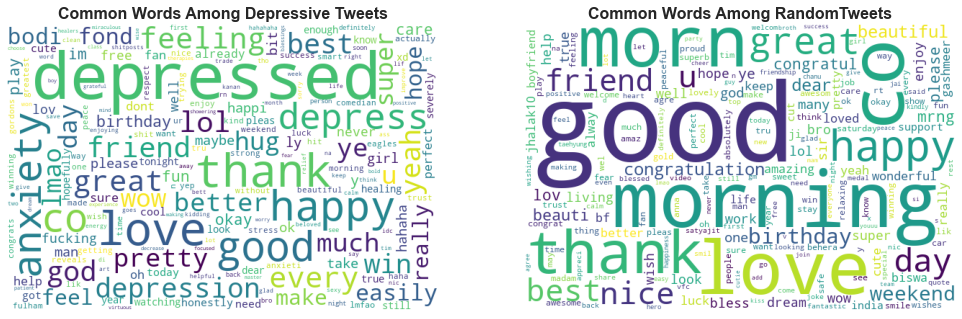

In [42]:
depressive_pos = ' '.join(depressive_tweets_pos.clean)
random_pos = ' '.join(random_tweets_pos.clean)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(depressive_pos)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(random_pos)

sns.set(rc={"figure.figsize":(17, 10)})
plt.subplot(1,2,1)
plt.title('Common Words Among Depressive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among RandomTweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

In [19]:
depressive_tweets_neg = depressive_tweets_df[depressive_tweets_df['negative sentiment'].between(0.25,1)]
random_tweets_neg = random_tweets_df[random_tweets_df['negative sentiment'].between(0.25,1)]

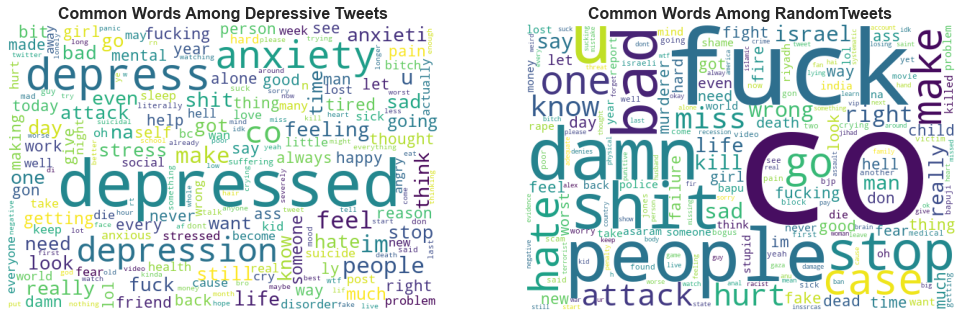

In [20]:
depressive_neg = ' '.join(depressive_tweets_neg.clean)
random_neg = ' '.join(random_tweets_neg.clean)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(depressive_neg)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(random_neg)

sns.set(rc={"figure.figsize":(17, 10)})
plt.subplot(1,2,1)
plt.title('Common Words Among Depressive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among RandomTweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

## Model Building

### Data Preparation

In [21]:
depressive_tweets_arr = [x for x in depressive_tweets_df['tweet']]
random_tweets_arr = [x for x in random_tweets_df['tweet']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [23]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [46]:
X_d[2]

'had worst anxiety yesterday double shot espresso how i supposed survive without coffe'

In [45]:
sequences_d[2]

[1354, 489, 4, 452, 1323, 909, 12754, 95, 1, 1066, 2491, 146, 8208]

In [24]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 44300 unique tokens


In [47]:
word_index

{'i': 1,
 'co': 2,
 'depressed': 3,
 'anxiety': 4,
 'like': 5,
 'the': 6,
 'good': 7,
 'get': 8,
 'depress': 9,
 'people': 10,
 'it': 11,
 'one': 12,
 'you': 13,
 'time': 14,
 'would': 15,
 'know': 16,
 'depression': 17,
 'day': 18,
 'us': 19,
 'make': 20,
 'u': 21,
 'feel': 22,
 'go': 23,
 'even': 24,
 '2': 25,
 'love': 26,
 'this': 27,
 'think': 28,
 'need': 29,
 'life': 30,
 'really': 31,
 'want': 32,
 'na': 33,
 'got': 34,
 'we': 35,
 'back': 36,
 'much': 37,
 'india': 38,
 'still': 39,
 'see': 40,
 '1': 41,
 'my': 42,
 'also': 43,
 'a': 44,
 'if': 45,
 'and': 46,
 'happy': 47,
 'morning': 48,
 'never': 49,
 'in': 50,
 'new': 51,
 'today': 52,
 'way': 53,
 'right': 54,
 '3': 55,
 'im': 56,
 'always': 57,
 'what': 58,
 'case': 59,
 'going': 60,
 'say': 61,
 'please': 62,
 'let': 63,
 'but': 64,
 'thank': 65,
 'no': 66,
 'help': 67,
 'look': 68,
 'best': 69,
 'take': 70,
 'he': 71,
 'great': 72,
 'that': 73,
 'could': 74,
 'someone': 75,
 'well': 76,
 'first': 77,
 'so': 78,
 'every'

In [25]:
data_d = pad_sequences(sequences_d[:12000], maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r[:12000], maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (12000, 140)
Shape of data_r tensor: (12000, 140)


In [26]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.key_to_index and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [27]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

### Creating a Baseline Model

In [29]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """`

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [30]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy


In [31]:
# Logistic Model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

In [32]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 52.062


In [41]:
print(classification_report(labels_test, y_logistic))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2400
           1       0.92      0.04      0.09      2400

    accuracy                           0.52      4800
   macro avg       0.72      0.52      0.38      4800
weighted avg       0.72      0.52      0.38      4800



### Building Model LSTM + CNN

In [33]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 300)          6000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 140, 32)           28832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                      

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
360/360 [==============================] - 58s 155ms/step - loss: 0.3803 - acc: 0.8116 - val_loss: 0.3063 - val_acc: 0.8540
Epoch 2/10
360/360 [==============================] - 54s 151ms/step - loss: 0.2915 - acc: 0.8643 - val_loss: 0.3061 - val_acc: 0.8381
Epoch 3/10
360/360 [==============================] - 53s 147ms/step - loss: 0.2571 - acc: 0.8838 - val_loss: 0.2894 - val_acc: 0.8654
Epoch 4/10
360/360 [==============================] - 51s 143ms/step - loss: 0.2256 - acc: 0.9009 - val_loss: 0.2924 - val_acc: 0.8660
Epoch 5/10
360/360 [==============================] - 55s 153ms/step - loss: 0.1995 - acc: 0.9160 - val_loss: 0.3038 - val_acc: 0.8687
Epoch 6/10
360/360 [==============================] - 54s 151ms/step - loss: 0.1710 - acc: 0.9292 - val_loss: 0.3218 - val_acc: 0.8681


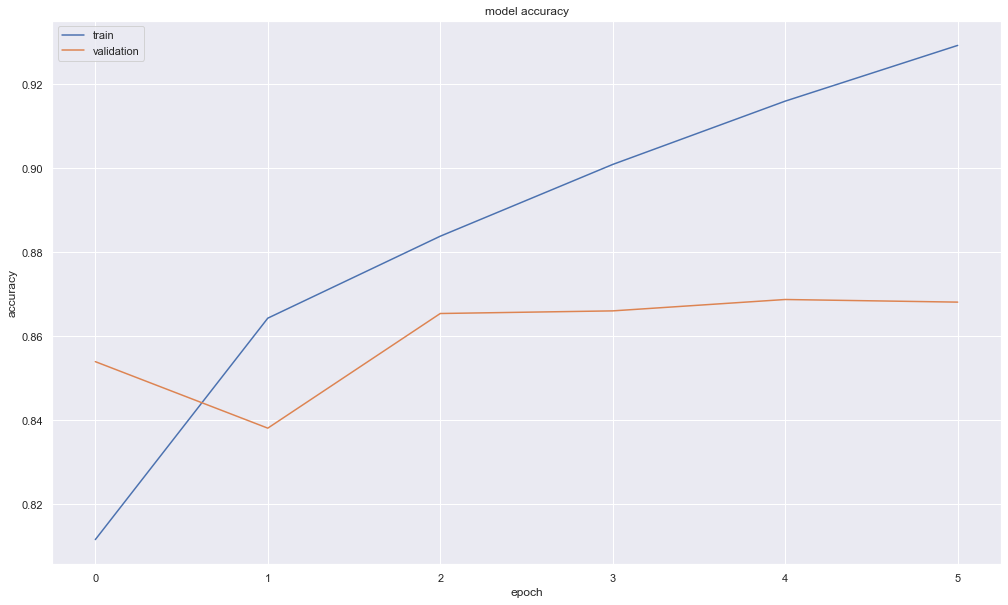

In [36]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

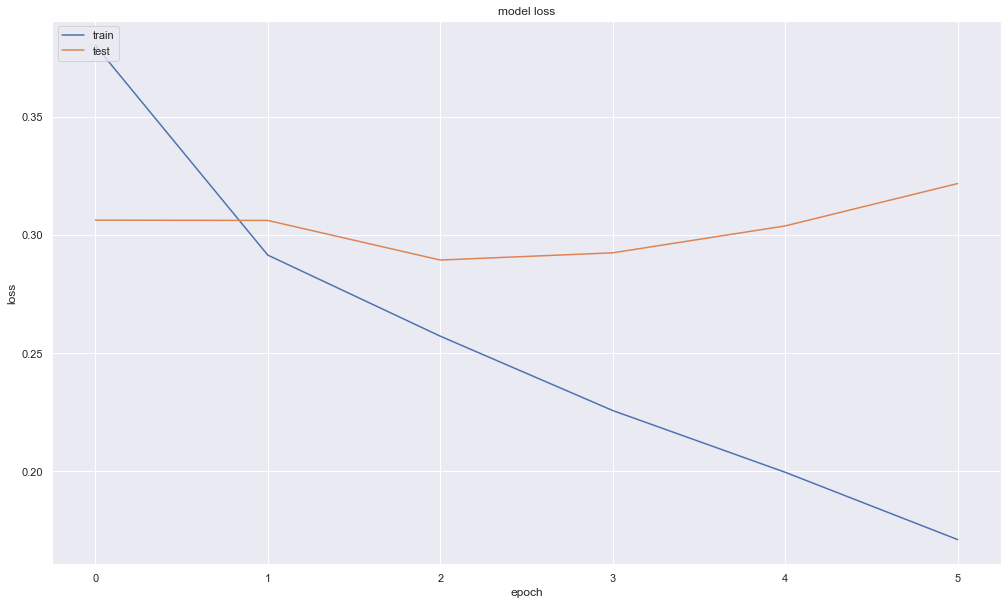

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 87.27%


In [40]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2400
           1       0.89      0.85      0.87      2400

    accuracy                           0.87      4800
   macro avg       0.87      0.87      0.87      4800
weighted avg       0.87      0.87      0.87      4800

